# Exercise 4 Solution: Calibrate and Project an SEIR Model with Interventions

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/tech-transfer-epydemix/blob/main/sessions/session-4/solutions/python/exercise_4_seir_calibration.ipynb)

**Scenario:** An outbreak occurs in California. After some time, interventions are implemented that reduce transmission. We will:

1. Generate synthetic data from an SEIR model with an intervention (β drops mid-epidemic)
2. Calibrate the model to recover the initial β and the reduction factor
3. Project forward under different scenarios (status quo vs. relaxation)

In [41]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from epydemix import EpiModel, simulate
from epydemix.population import load_epydemix_population
from epydemix.calibration import ABCSampler, rmse
from epydemix.visualization import plot_quantiles, plot_posterior_distribution
from epydemix.utils import compute_simulation_dates

colors = sns.color_palette("Dark2")

## Task 1: Generate Synthetic Data

We create an SEIR model for California where:
- Initial β = 0.035 (baseline transmission)
- On day 50, interventions reduce β to 60% of original (reduction_factor = 0.6)
- The epidemic runs for 120 days total

In [43]:
# True parameters (what we'll try to recover)
TRUE_BETA = 0.035
TRUE_REDUCTION = 0.6  # β drops to 60% of original (40% reduction)
INTERVENTION_DAY = 50

# Simulation settings
START_DATE = "2026-01-01"
END_DATE = "2026-04-30"  # 120 days
CALIBRATION_END = "2026-03-15"  # Calibrate up to day 74

# Fixed disease parameters
SIGMA = 0.2   # 5-day latent period
GAMMA = 0.1   # 10-day infectious period

In [44]:
# Create the "true" model that generates our data
def create_seir_model():
    model = EpiModel(name="SEIR", compartments=["S", "E", "I", "R"])
    
    model.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")
    model.add_transition(source="E", target="I", params="sigma", kind="spontaneous")
    model.add_transition(source="I", target="R", params="gamma", kind="spontaneous")
    
    model.add_parameter("beta", TRUE_BETA)
    model.add_parameter("sigma", SIGMA)
    model.add_parameter("gamma", GAMMA)
    
    # Load California population
    population = load_epydemix_population("United_States_California")
    model.set_population(population)
    
    return model

# Create model and add intervention
model_truth = create_seir_model()

# Add intervention: β drops to TRUE_BETA * TRUE_REDUCTION after day 30
from datetime import datetime, timedelta
intervention_date = (datetime.strptime(START_DATE, "%Y-%m-%d") + timedelta(days=INTERVENTION_DAY)).strftime("%Y-%m-%d")

model_truth.override_parameter(
    start_date=intervention_date,
    end_date=END_DATE,
    parameter_name="beta",
    value=TRUE_BETA * TRUE_REDUCTION
)

print(f"Intervention date: {intervention_date}")
print(f"β before intervention: {TRUE_BETA}")
print(f"β after intervention: {TRUE_BETA * TRUE_REDUCTION}")

Intervention date: 2026-02-20
β before intervention: 0.035
β after intervention: 0.021


In [45]:
# Generate synthetic data
population = model_truth.population

# Initial conditions: seed with ~100 infected
initial_infected = 1000
n_groups = len(population.Nk)
infected_per_group = np.full(n_groups, initial_infected // n_groups)

initial_conditions = {
    "S": population.Nk - infected_per_group,
    "E": np.zeros(n_groups),
    "I": infected_per_group,
    "R": np.zeros(n_groups)
}

# Run one simulation to generate "observed" data
results_truth = model_truth.run_simulations(
    start_date=START_DATE,
    end_date=END_DATE,
    Nsim=1,
    initial_conditions_dict=initial_conditions
)

# Extract incidence (S→E transitions)
incidence = results_truth.get_stacked_transitions()["E_to_I_total"][0]  # First (only) simulation
dates = pd.date_range(start=START_DATE, periods=len(incidence), freq="D")

# Create data DataFrame
data = pd.DataFrame({"date": dates, "data": incidence})
print(f"Generated {len(data)} days of data")
print(f"Peak incidence: {data['data'].max():.0f} on day {data['data'].argmax()}")

Generated 120 days of data
Peak incidence: 769368 on day 79


In [46]:
# Split into calibration and projection periods
calibration_end_date = pd.to_datetime(CALIBRATION_END)
data_calibration = data[data["date"] <= calibration_end_date].copy()
data_projection = data[data["date"] > calibration_end_date].copy()

print(f"Calibration: {data_calibration.date.iloc[0].date()} to {data_calibration.date.iloc[-1].date()} ({len(data_calibration)} days)")
print(f"Projection:  {data_projection.date.iloc[0].date()} to {data_projection.date.iloc[-1].date()} ({len(data_projection)} days)")

Calibration: 2026-01-01 to 2026-03-15 (74 days)
Projection:  2026-03-16 to 2026-04-30 (46 days)


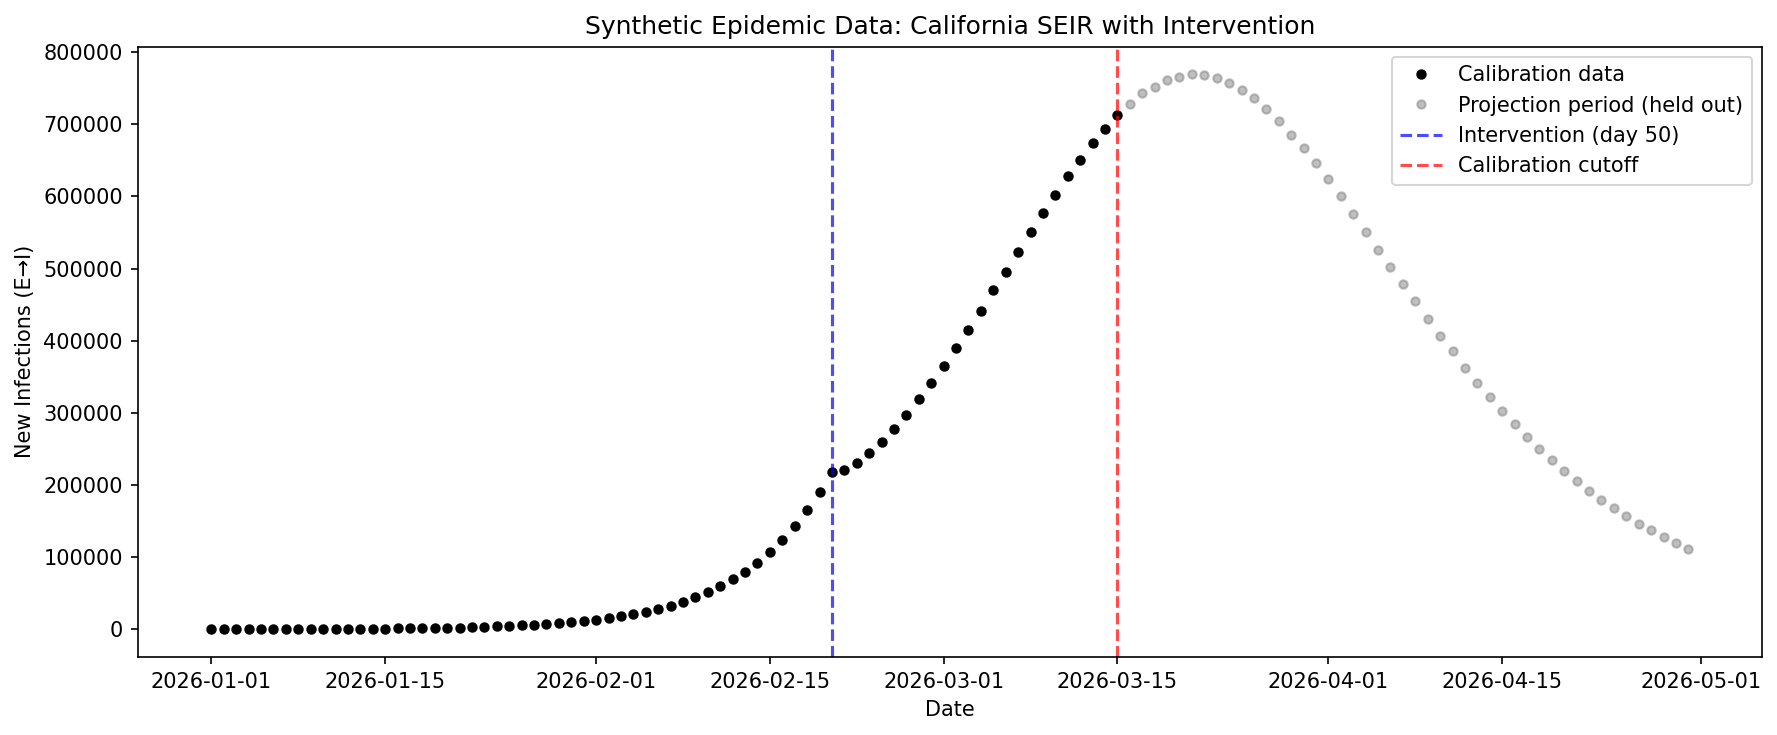

In [47]:
# Visualize the synthetic data
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

ax.plot(data_calibration["date"], data_calibration["data"], "ko", markersize=4, label="Calibration data")
ax.plot(data_projection["date"], data_projection["data"], "o", color="gray", 
        markersize=4, alpha=0.5, label="Projection period (held out)")

# Mark intervention and calibration cutoff
ax.axvline(pd.to_datetime(intervention_date), color="blue", linestyle="--", alpha=0.7, label=f"Intervention (day {INTERVENTION_DAY})")
ax.axvline(calibration_end_date, color="red", linestyle="--", alpha=0.7, label="Calibration cutoff")

ax.set_xlabel("Date")
ax.set_ylabel("New Infections (E→I)")
ax.set_title("Synthetic Epidemic Data: California SEIR with Intervention")
ax.legend()

plt.tight_layout()

## Task 2: Set Up the Calibration Model

We'll calibrate two parameters:
- `beta`: Initial transmission rate (before intervention)
- `reduction`: The factor by which β is reduced after the intervention

In [48]:
model = EpiModel(name="SEIR", compartments=["S", "E", "I", "R"])

model.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")
model.add_transition(source="E", target="I", params="sigma", kind="spontaneous")
model.add_transition(source="I", target="R", params="gamma", kind="spontaneous")

model.add_parameter("sigma", SIGMA)
model.add_parameter("gamma", GAMMA)

# Load California population
pop = load_epydemix_population("United_States_California")
model.set_population(pop)

In [49]:
OVERRIDE_END_DATE = pd.to_datetime(END_DATE)

def simulate_wrapper(parameters):
    """Wrapper that creates model with sampled parameters and runs simulation."""
    # Extract sampled parameters
    reduction = parameters.get("reduction", 1.0)
    beta = parameters.get("beta", 0.035)
    
    # Add intervention
    parameters["epimodel"].clear_overrides()
    parameters["epimodel"].override_parameter(
        start_date=intervention_date,
        end_date=OVERRIDE_END_DATE,
        parameter_name="beta",
        value=beta * reduction
    )
    
    # Run simulation
    results = simulate(**parameters)
    
    return {"data": results.transitions["E_to_I_total"]}

## Task 3: Define Priors and Run Calibration

In [50]:
# Define priors
priors = {
    "beta": stats.uniform(0.02, 0.025),      # U(0.02, 0.045)
    "reduction": stats.uniform(0.3, 0.6)      # U(0.3, 0.9) - reduction factor
}

print("Prior distributions:")
print(f"  beta: U(0.02, 0.045)")
print(f"  reduction: U(0.3, 0.9)")
print(f"\nTrue values: beta={TRUE_BETA}, reduction={TRUE_REDUCTION}")

Prior distributions:
  beta: U(0.02, 0.045)
  reduction: U(0.3, 0.9)

True values: beta=0.035, reduction=0.6


In [51]:
# Create base model for calibration
model_calib = create_seir_model()

# Calibration parameters
calibration_parameters = {
    "initial_conditions_dict": initial_conditions,
    "epimodel": model_calib,
    "start_date": START_DATE,
    "end_date": CALIBRATION_END, 
}

# Initialize ABC sampler
abc_sampler = ABCSampler(
    simulation_function=simulate_wrapper,
    priors=priors,
    parameters=calibration_parameters,
    observed_data=data_calibration["data"].values,
    distance_function=rmse
)

In [52]:
# Run ABC-SMC calibration
print("Running calibration...")
calibration_results = abc_sampler.calibrate(
    strategy="smc",
    num_particles=100,
    num_generations=5
)
print("Done!")

Running calibration...
Starting ABC-SMC with 100 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:05

Generation 2/5 (epsilon: 228008.305890)
	Accepted 100/162 (acceptance rate: 61.73%)
	Elapsed time: 00:00:08

Generation 3/5 (epsilon: 149991.583622)
	Accepted 100/250 (acceptance rate: 40.00%)
	Elapsed time: 00:00:11

Generation 4/5 (epsilon: 85239.683430)
	Accepted 100/391 (acceptance rate: 25.58%)
	Elapsed time: 00:00:22

Generation 5/5 (epsilon: 52248.908437)
	Accepted 100/621 (acceptance rate: 16.10%)
	Elapsed time: 00:00:28
Done!


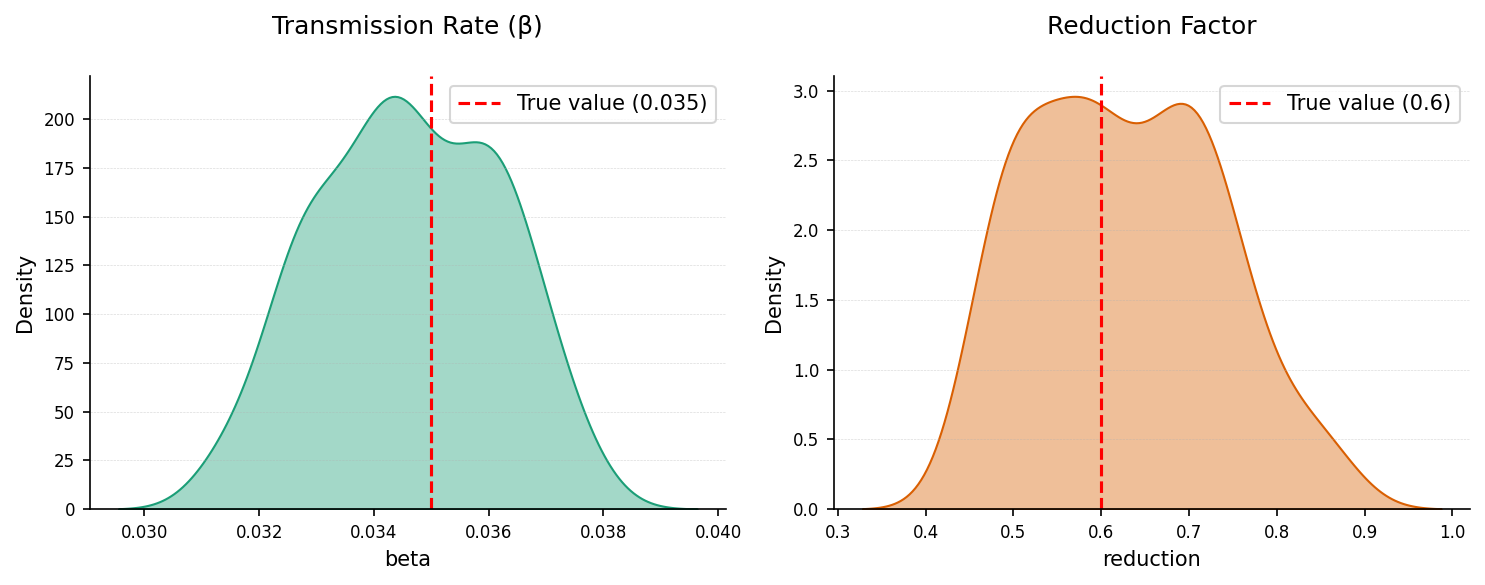

In [53]:
# Visualize posterior distributions
posterior = calibration_results.get_posterior_distribution()

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

# Beta posterior
plot_posterior_distribution(posterior, "beta", ax=axes[0], kind="kde", 
                           title="Transmission Rate (β)", color=colors[0])
axes[0].axvline(TRUE_BETA, color="red", linestyle="--", label=f"True value ({TRUE_BETA})")
axes[0].legend()

# Reduction posterior
plot_posterior_distribution(posterior, "reduction", ax=axes[1], kind="kde",
                           title="Reduction Factor", color=colors[1])
axes[1].axvline(TRUE_REDUCTION, color="red", linestyle="--", label=f"True value ({TRUE_REDUCTION})")
axes[1].legend()

plt.tight_layout()

In [54]:
# Print posterior summaries
print("Posterior estimates vs True values:")
print(f"{'Parameter':<12} {'Median':<10} {'IQR':<20} {'True':<10}")
print("-" * 52)

for param, true_val in [("beta", TRUE_BETA), ("reduction", TRUE_REDUCTION)]:
    values = posterior[param].values
    med = np.median(values)
    q25, q75 = np.percentile(values, [25, 75])
    print(f"{param:<12} {med:<10.4f} [{q25:.4f}, {q75:.4f}]   {true_val:<10.4f}")

Posterior estimates vs True values:
Parameter    Median     IQR                  True      
----------------------------------------------------
beta         0.0346     [0.0334, 0.0359]   0.0350    
reduction    0.6114     [0.5343, 0.7063]   0.6000    


## Task 4: Project Under Alternative Scenarios

We'll compare two scenarios for the projection period:

1. **Status quo**: Interventions remain in place (β stays reduced)
2. **Relaxation**: Interventions are lifted (β returns to baseline)

In [55]:
from epydemix.utils import compute_simulation_dates

# Run projections for each scenario
print("Running scenario projections...")

# Run projections (status quo - interventions maintained)
params_status_quo = calibration_parameters.copy()
params_status_quo["end_date"] = data_projection.date.values[-1]
results_status_quo = abc_sampler.run_projections(params_status_quo)
print("  Status quo: done")

# Run projections (relaxation - interventions lifted)
params_relaxation = calibration_parameters.copy()
params_relaxation["end_date"] = data_projection.date.values[-1]
OVERRIDE_END_DATE = CALIBRATION_END  # Stop intervention at calibration end
results_relaxation = abc_sampler.run_projections(params_relaxation)
print("  Relaxation: done")

# Compute projection dates
projection_dates = compute_simulation_dates(
    start_date=params_status_quo["start_date"],
    end_date=params_status_quo["end_date"],
)

# Get quantiles for plotting
df_status_quo = results_status_quo.get_projection_quantiles(projection_dates)
df_relaxation = results_relaxation.get_projection_quantiles(projection_dates)

Running scenario projections...
  Status quo: done
  Relaxation: done


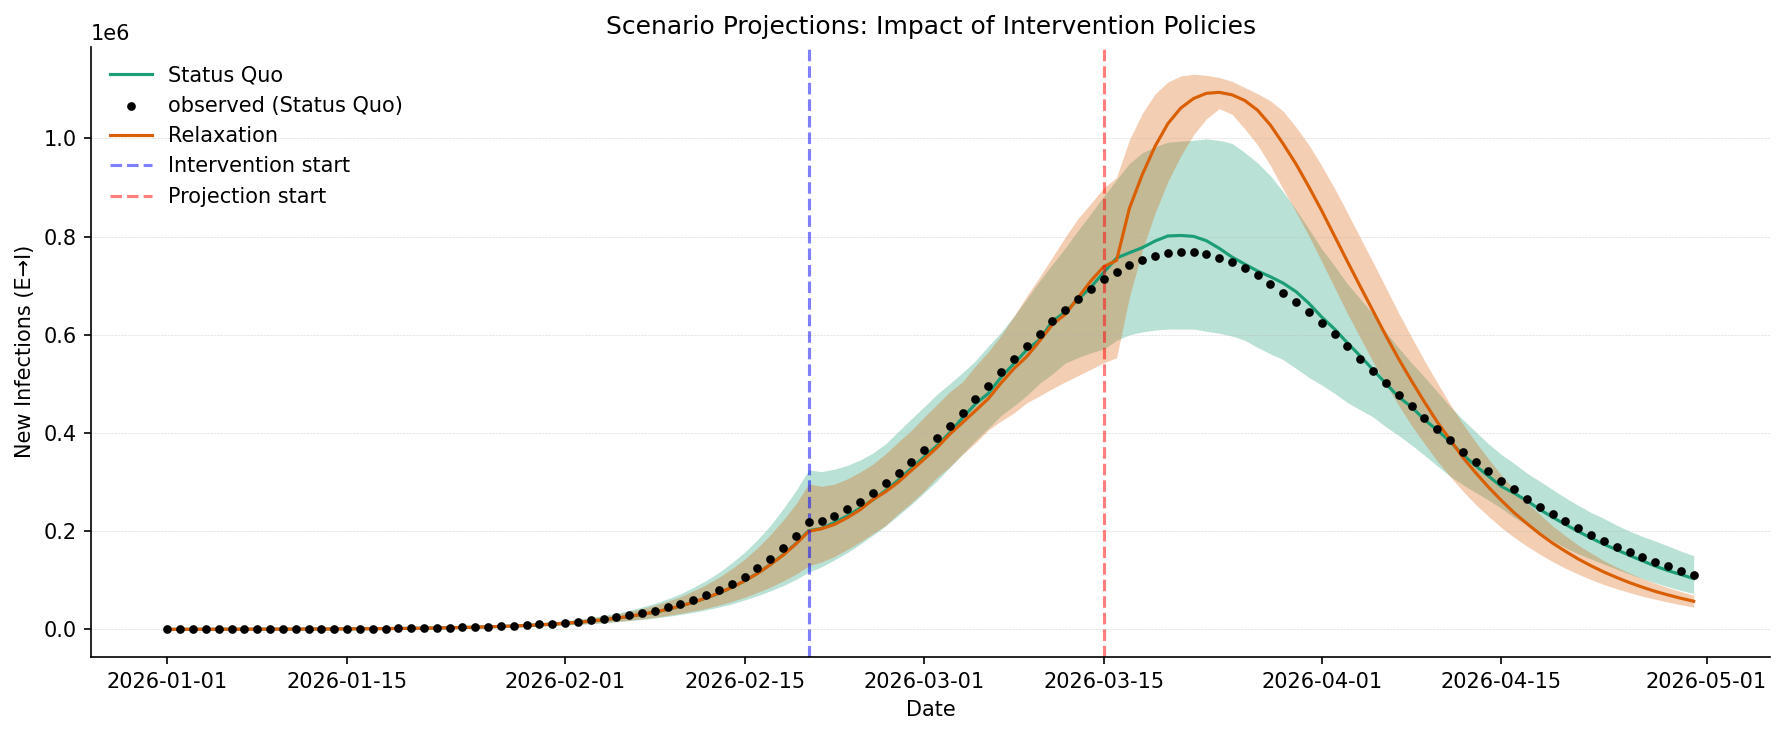

In [56]:
# Plot scenario comparison (time series)
fig, ax = plt.subplots(dpi=150, figsize=(12, 5))

plot_quantiles(df_status_quo, columns="data", data=data, ax=ax, colors=colors[0], 
               show_legend=False, show_data=True, labels=["Status Quo"])
plot_quantiles(df_relaxation, columns="data", ax=ax, colors=colors[1], 
               show_legend=False, show_data=False, labels=["Relaxation"])

# Mark key dates
ax.axvline(pd.to_datetime(intervention_date), color="blue", linestyle="--", alpha=0.5, label="Intervention start")
ax.axvline(pd.to_datetime(CALIBRATION_END), color="red", linestyle="--", alpha=0.5, label="Projection start")

ax.legend(loc="upper left", frameon=False)
ax.set_xlabel("Date")
ax.set_ylabel("New Infections (E→I)")
ax.set_title("Scenario Projections: Impact of Intervention Policies")

plt.tight_layout()

## Discussion

**Key findings:**

1. **Parameter recovery**: The calibration successfully recovered the true values of β and the reduction factor, demonstrating that ABC-SMC can identify intervention effects from incidence data.

2. **Scenario projections**: The two scenarios show different outcomes:
   - **Status quo**: Continuing interventions keeps transmission reduced, leading to a controlled decline in infections
   - **Relaxation**: Lifting interventions allows β to return to baseline, resulting in higher transmission during the projection period

**Policy implications:**
- Premature relaxation of interventions can lead to increased infections
- Model projections provide a framework for comparing policy options under uncertainty
- Decision-makers can use these projections to weigh trade-offs between maintaining restrictions and relaxing them

**Limitations:**
- This exercise uses synthetic data; real-world data has additional complexities (reporting delays, changing behavior, etc.)
- We assumed known intervention timing; in practice, this may need to be estimated
- The model assumes homogeneous mixing and does not account for spatial heterogeneity